Szymon Rogowski (405244)
Projekt

Nr:5. Dany jest obraz kolorowy zawierający obiekty o różnej jasności,
za pomocą operacji morfologicznej dylatacji i erozji znajdź na obrazie krawędzie obiektów.
Zmierz długości krawędzi obiektów a wynik przedstaw w postaci histogramu.

In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import math
import re
from skimage import io, color
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import binary_dilation, binary_erosion, disk, skeletonize
from skimage.measure import find_contours
from skimage import morphology
from scipy.ndimage import gaussian_filter

print("Libs loaded.")

Libs loaded.


1. Należy wczytać obrazy w co najmniej w jednym formacie bezstratnej kompresji.
2. Program rysuje opisane, znormalizowane histogramy dla wczytanego i przetwarzanego obrazu.
3. Kolejno prezentuje wyniki w postaci obrazów, opisanych wykresów, tabel, schematów i plików.
4. Pozwala na zapis końcowego obrazu w co najmniej jednym formacie bezstratnej kompresji.

In [136]:
lena_image_path = 'images/lena.png'
coins_image_path = 'images/coins.jpg'
lights_image_path = 'images/lights.jpg'
sunflowers_image_path = 'images/sunflowers.jpg'

In [137]:
def extract_image_name(file_path):
    pattern = re.compile(r'[^/\\]*(?=\.\w+$)')
    match = re.search(pattern, file_path)
    image_name = match.group(0)
    return image_name

In [138]:
def luminance_histogram(image_path, name):
    with Image.open(image_path) as img:
        width, height = img.size

    image = cv2.imread(image_path)

    if image.shape[1] == width and image.shape[0] == height:
        print("Lossless compression.")
    else:
        print("Lossy compression.")

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    plt.hist(gray_image.ravel(), bins=256, color='gray', alpha=0.7)  #  funkcja plt.hist() w Matplotlib automatycznie normalizuje histogram
    plt.title(f'Histogram Jasności - {name}')
    plt.xlabel('Wartość Jasności')
    plt.ylabel('Liczba Pikseli')
    plt.show()
    return name

Lossless compression.


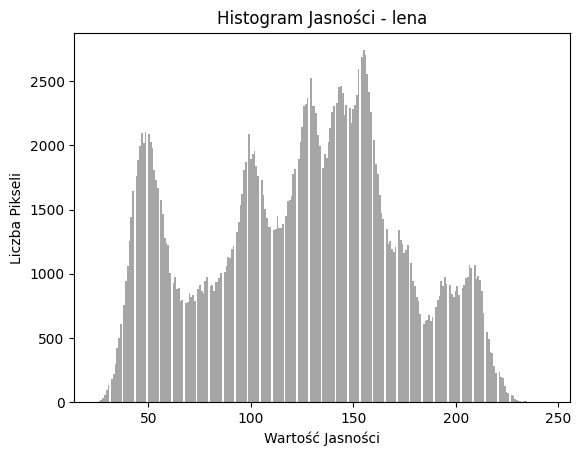

Lossless compression.


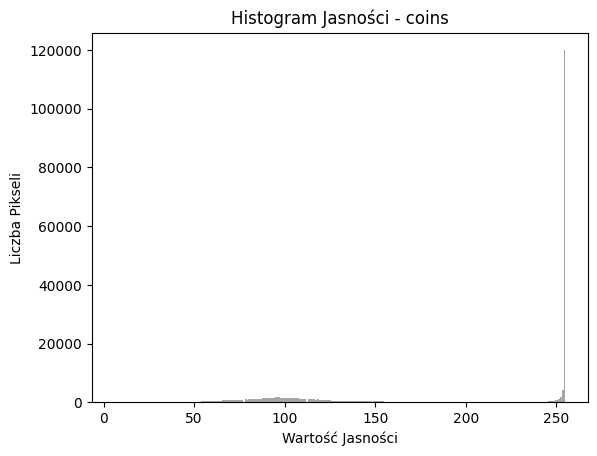

Lossless compression.


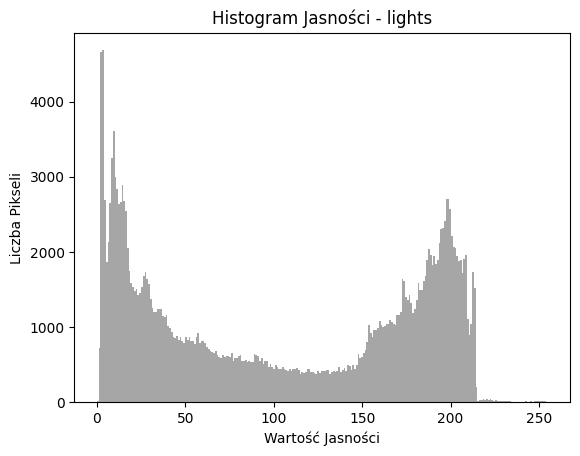

Lossless compression.


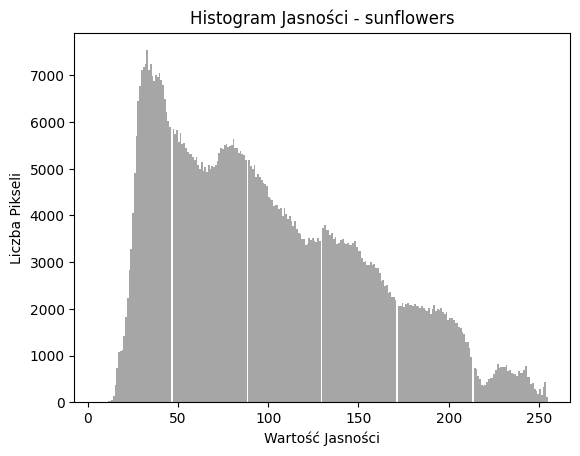

In [139]:
lena_image_name = luminance_histogram(lena_image_path, extract_image_name(lena_image_path))
coins_image_name = luminance_histogram(coins_image_path, extract_image_name(coins_image_path))
lights_image_name = luminance_histogram(lights_image_path, extract_image_name(lights_image_path))
sunflowers_image_name = luminance_histogram(sunflowers_image_path, extract_image_name(sunflowers_image_path))

In [140]:
# Out of the box tests:
#
# gray_image = color.rgb2gray(image)
#
# edges = sobel(gray_image)
#
# plt.subplot(1, 2, 1)
# plt.imshow(gray_image, cmap='gray')
# plt.title('Obraz Oryginalny')
#
# plt.subplot(1, 2, 2)
# plt.imshow(edges, cmap='gray')
# plt.title('Detekcja Krawędzi')
#
# plt.show()

In [150]:
def edge_detection(image_path, image_name, shouldSkeletonize):
    image = cv2.imread(image_path)
    gray_image = color.rgb2gray(image)
    # Binaryzacja Otsu do podziału obrazu na obszary białe i czarne. Binaryzacja pomaga w późniejszych operacjach morfologicznych, ponieważ te operacje są zwykle stosowane na obrazach binarnych, gdzie piksele są przypisane do jednej z dwóch wartości (czarny - biały).
    threshold_value = threshold_otsu(gray_image)
    binary_image = gray_image > threshold_value

    # Element strukturalny (maska operacji morfologicznych) w kształcie dysku o promieniu 3 pikseli. Następnie przeprowadzane są operacje dylatacji i erozji na obrazie binarnym.
    selem = disk(3)
    dilated_image = binary_dilation(binary_image, selem)
    eroded_image = binary_erosion(binary_image, selem)

    # Operacja XOR jest używana, ponieważ różnicuje obszary, gdzie jedno z dwóch działań morfologicznych (dylatacji, erozji) miało wpływ. Różnicowanie jest używane do wskazania obszarów, gdzie zachodzi zmiana intensywności pikseli.
    # XOR zwraca prawdę (1), gdy jedno z dwóch porównywanych pikseli jest prawdą (1), a drugie fałszem (0).
    #     Po zastosowaniu operacji dylatacji na obrazie binarnym, obszary obiektów są poszerzane.
    #     Po zastosowaniu operacji erozji, obszary obiektów są zwężane.
    #  XOR między obrazem po dylatacji a obrazem po erozji zwraca wartość prawdy (1) dla pikseli, które różnią się między tymi dwoma obrazami.
    # Piksele, które są wspólne dla obu obrazów, są oznaczone jako fałsz (0).
    # Piksele, które różnią się między obrazem po dylatacji a obrazem po erozji, odpowiadają obszarom, gdzie operacje morfologiczne miały wpływ na strukturę obiektów - obszary krawędzi.
    # Wynik edges to mapa binarna, gdzie wartości 1 wskazują obszary krawędzi, a wartości 0 wskazują obszary wewnątrz obiektów.
    edges = dilated_image ^ eroded_image

    if shouldSkeletonize:
        skeleton = morphology.skeletonize(edges)


    # Wartość jest interpretowana jako stosunek wysokości konturu do szerokości - 0.8 => 80% - mogą wynikać z szumów na obrazie.
    # Algorytm używany w funkcji wedle dokumentacji: marching squares method zastosowany na mapie binarnej krawędzi, który polega na:
    # 1. Podział obrazu na kwadraty:
    #     - Obraz dzielony jest na kwadraty o rozmiarze 2x2 piksele.
    #     - Każdy kwadrat reprezentuje lokalny fragment obrazu.
    # 2. Przypisanie wartości binarnej do wierzchołków kwadratu:
    #     - Każdemu z czterech wierzchołków kwadratu przypisuje się wartość binarną (0 lub 1) w zależności od tego, czy piksel znajdujący się w tym punkcie należy do obszaru o intensywności większej czy mniejszej od progu.
    # 3. Konfiguracja kwadratu:
    # W wyniku przypisania wartości binarnej do wierzchołków, otrzymuje się 16 możliwych konfiguracji (2^4), ponieważ każdy z czterech wierzchołków może przyjąć jedną z dwóch wartości binarnych.
    # 4. Interpolacja krawędzi:
    #     - Dla każdej konfiguracji kwadratu, algorytm ten korzysta z zestawu reguł, aby określić, które krawędzie kwadratu są przecinane przez krawędzie obiektów na obrazie.
    #     - Wprowadza się numerację krawędzi kwadratu, nadając numer każdej z czterech krawędzi.
    #     - Dla danej konfiguracji kwadratu, istnieje zestaw reguł, które określają, które krawędzie są przecinane przez obiekt. Reguły te zależą od tego, które z wierzchołków kwadratu leżą na przeciwnych stronach obiektu.
    #     - Na podstawie konfiguracji i reguł, algorytm ustala, które krawędzie są przecinane przez obiekt. Otrzymuje się informacje o tym, które wierzchołki kwadratu leżą na przeciwnych stronach obiektu.
    #     - Interpolacja polega na wyznaczeniu punktów przecięcia krawędzi kwadratu z obiektem. Jeśli pewna krawędź jest przecinana, algorytm oblicza współrzędne punktu przecięcia na tej krawędzi.
    # 5. Rysowanie krawędzi:
    # Na podstawie wyznaczonych punktów przecięcia, algorytm tworzy kontur obiektu wewnątrz kwadratu. Kontur ten reprezentuje granice obiektu na mapie binarnej.
    if shouldSkeletonize:
        contours = find_contours(skeleton, 0.8)
    else:
        contours = find_contours(edges, 0.8)
    # Wynikiem poprzedniej operacji jest lista konturów, gdzie każdy kontur jest tablicą 2D, a każda kolumna zawiera współrzędne y i x punktów konturu.

    edge_lengths = [len(contour) for contour in contours]

    plt.figure(figsize=(12, 6))


    # Możliwa Szkieletyzacja do zmniejszenia rozmiaru grubości stworzonych krawędzi na obrazie. Szkieletyzacja to proces redukcji szerokości białych obszarów na obrazie do minimalnej wymaganej, jednopikselowej ścieżki, jednocześnie zachowując topologię obiektu. Szkielet (skeleton) reprezentuje strukturę obiektu w formie wąskiej linii, co jest szczególnie przydatne w analizie obrazów, rozpoznawaniu kształtów i innych dziedzinach przetwarzania obrazów.
    # Istnieje wiele algorytmów szkieletyzacji, a jeden z popularnych to algorytm "thin" (ang. "thinning").
    # Ogólny proces tego algorytmu składa się z kroków: binaryzacji obrazu, inicjalizacja szkieletu, iteracyjnym usuwaniu pikseli, zakończenie procesu warunkiem stopu.
    # Ostateczny szkielet reprezentuje strukturę obiektów w oryginalnym obrazie, przy minimalnej szerokości i zachowaniu kluczowych cech topologicznych.
    plt.subplot(2, 2, 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title(f'Obraz Oryginalny - {image_name}')

    if shouldSkeletonize:
        plt.subplot(2, 2, 2)
        plt.imshow(skeleton, cmap='gray')
        plt.title(f'Detekcja Krawędzi - {image_name}')
    else:
        plt.subplot(2, 2, 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Detekcja Krawędzi - {image_name}')
    plt.show()

    # Sprawdzenie czy w jakiś sposóv rodzielczość straciła wartość, jeśli nie to obraz zostaje z taką samą rozdzielczością jak został zaaplikowany do funkcji.
    output = skeleton if shouldSkeletonize else edges
    if gray_image.shape[:2] == output.shape:
        original_extension = image_path.split('.')[-1].lower()
        saved_image_path = f'saved_images/{image_name}_edges.{original_extension}'
        cv2.imwrite(saved_image_path, (output * 255).astype(np.uint8))
        print(f'Original Image Shape (Resolution) ({image_name}): {gray_image.shape}')
        print(f'Edges Image Shape (Resolution) ({image_name}): {output.shape}')
        print("Image successfully saved to saved_images/ folder.")
    else:
        print("Error: Resolutions of the original and processed images do not match.")
        return None, None

    return edges, edge_lengths

def edge_length_histogram(edge_lengths, image_name):
    plt.hist(edge_lengths, bins=50, color='red', alpha=0.7)
    plt.title(f'Histogram Długości Krawędzi - {image_name}')
    plt.xlabel('Długość Krawędzi')
    plt.ylabel('Liczba Krawędzi')

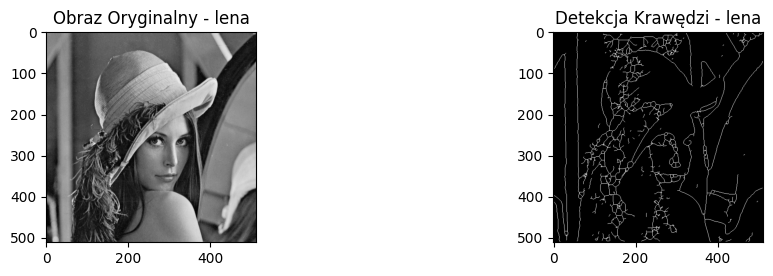

Original Image Shape (Resolution) (lena): (512, 512)
Edges Image Shape (Resolution) (lena): (512, 512)
Image successfully saved to saved_images/ folder.


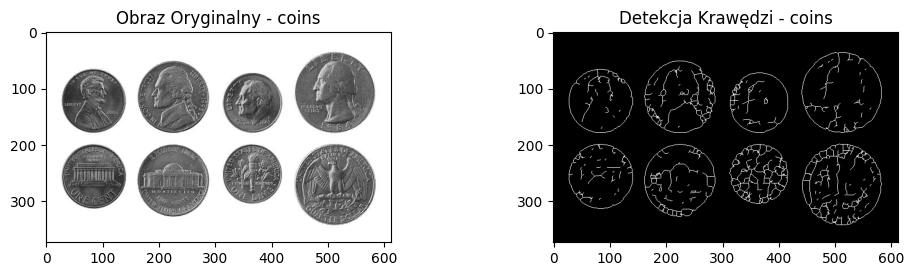

Original Image Shape (Resolution) (coins): (373, 612)
Edges Image Shape (Resolution) (coins): (373, 612)
Image successfully saved to saved_images/ folder.


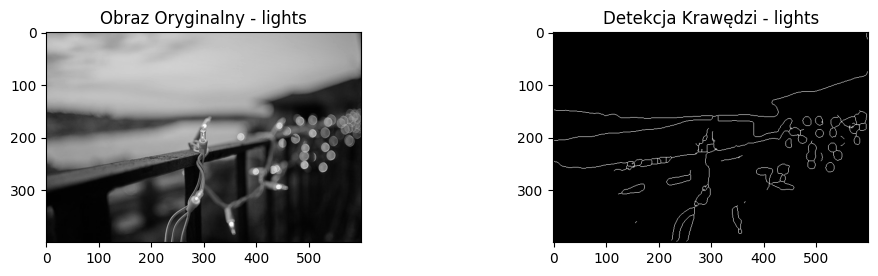

Original Image Shape (Resolution) (lights): (400, 600)
Edges Image Shape (Resolution) (lights): (400, 600)
Image successfully saved to saved_images/ folder.


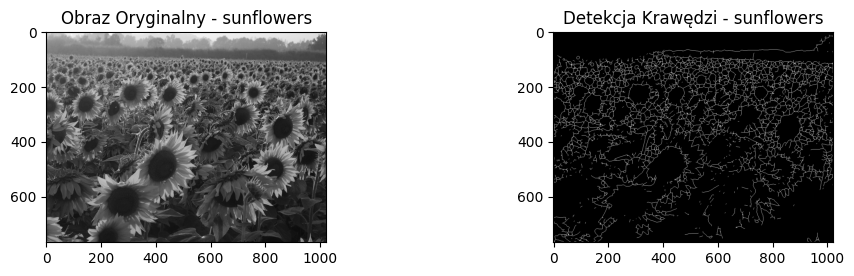

Original Image Shape (Resolution) (sunflowers): (767, 1023)
Edges Image Shape (Resolution) (sunflowers): (767, 1023)
Image successfully saved to saved_images/ folder.


In [151]:
edges_image_lena, edge_lengths_lena = edge_detection(lena_image_path, lena_image_name, True)
edges_image_coins, edge_lengths_coins = edge_detection(coins_image_path, coins_image_name, True)
edges_image_lights, edge_lengths_lights = edge_detection(lights_image_path, lights_image_name, True)
edges_image_sunflowers, edge_lengths_sunflowers = edge_detection(sunflowers_image_path, sunflowers_image_name, True)

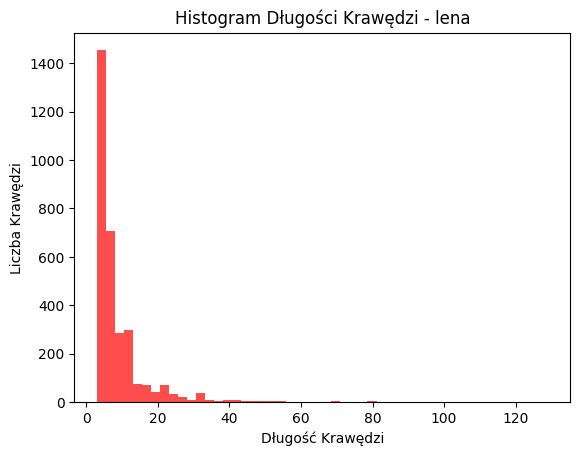

In [143]:
edge_length_histogram(edge_lengths_lena, lena_image_name)

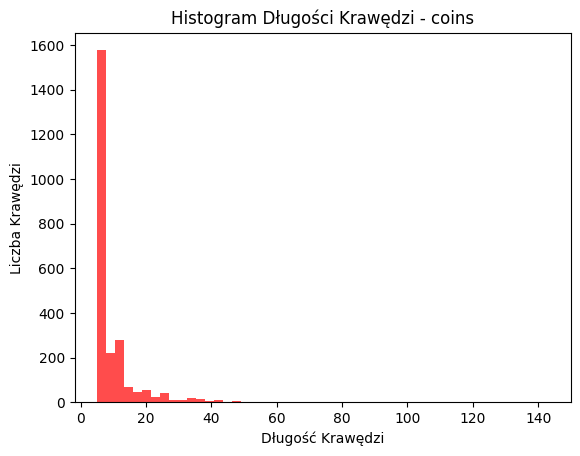

In [144]:
edge_length_histogram(edge_lengths_coins, coins_image_name)

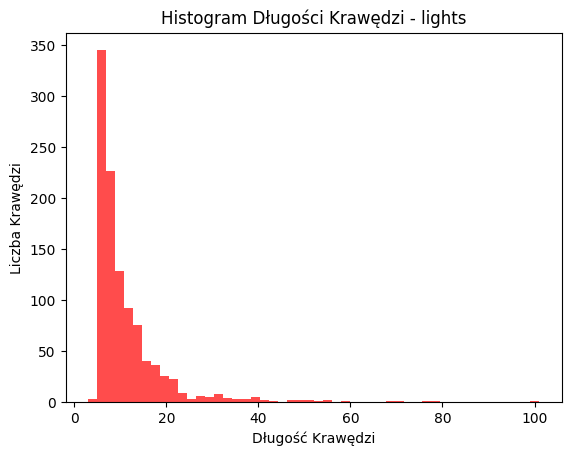

In [145]:
edge_length_histogram(edge_lengths_lights, lights_image_name)

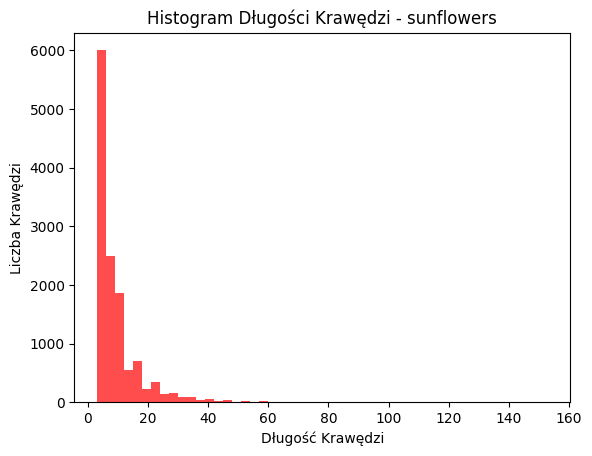

In [146]:
edge_length_histogram(edge_lengths_sunflowers, sunflowers_image_name)

In [147]:
# Bibliografia:
# •	MIT Boston, USA: http://fab.cba.mit.edu/classes/S62.12/docs/Lorensen_marching_cubes.pdf
# •	Carleton University Ottawa, Canada: https://www.cs.carleton.edu/cs_comps/0405/shape/marching_cubes.html
# •	Politechnika Katalońska: https://www.cs.upc.edu/~virtual/SGI/docs/1.%20Theory/Unit%2010.%20Volume%20models.%20Marching%20Cubes/Marching%20Cubes.pdf
# •	Stanford, USA: https://graphics.stanford.edu/~mdfisher/MarchingCubes.html
